In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

%matplotlib inline

In [2]:
#all variables
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'
data_abundance ='Data/abundance'

In [3]:

#The biggest differences were found between the sterile and non-sterile environment during beta-
#diversity analysis, so these will be looked at. 

In [3]:
#First, we look at the distribution of our data. 
data = q2.Artifact.load(f'{data_raw}/modified-dada1-table-highschool.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
data.shape

(548, 19899)

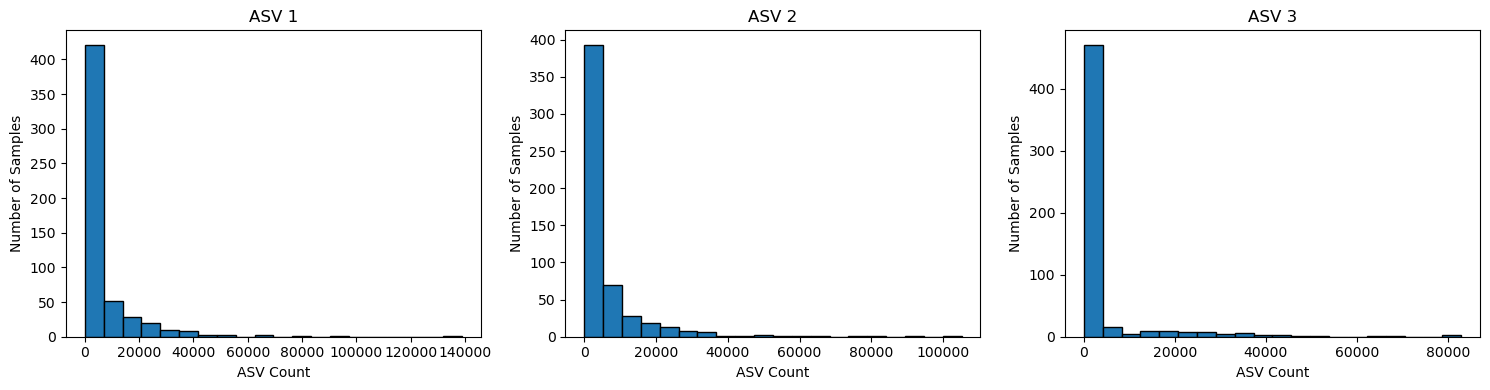


Top 3 ASV identifiers:
1. f228dd6b54c8587a0e366a57ab4d0904 (total: 3150979.0)
2. 23f8d77e0da2129f8b93b5ca894b5771 (total: 3065488.0)
3. c1f82285dd8e54d0759cc5b4589bd81e (total: 1907950.0)


In [6]:
data
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum().nlargest(3).index]
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
# View each as a histogram showing number of samples per ASV count value
import matplotlib.pyplot as plt

top_asv_names = top_three.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


for i, asv in enumerate(top_asv_names):
    axes[i].hist(top_three[asv], bins=20, edgecolor='black')
    axes[i].set_xlabel('ASV Count')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_title(f'ASV {i+1}')

plt.tight_layout()
plt.show()

# Print the actual ASV identifiers
print("\nTop 3 ASV identifiers:")
for i, asv in enumerate(top_asv_names, 1):
    print(f"{i}. {asv} (total: {data[asv].sum()})")

In [13]:
#based on the shape of the data and the distribution of above, the following parameters for
#filtering were chosen
! qiime feature-table filter-features \
  --i-table $data_raw/modified-dada1-table-highschool.qza \
  --p-min-frequency 50 \
  --p-min-samples 10 \
  --o-filtered-table $data_abundance/table_abund.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund.qza


In [7]:
#Check if there are any other values than sterile and non-sterile in the merged metadata in the background column
md_merged = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
md_merged['background'].unique()

array(['non-sterile', 'sterile', nan], dtype=object)

In [15]:
#we want to look at differences betwen non-sterile and sterile environment, since nan values are in df, filter for 
#sterile and non-sterile values
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[background]='sterile' OR [background]='non-sterile'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile.qza


In [16]:
#make it into a visualization
! qiime feature-table summarize \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-sample-metadata-file $data_raw/merged_output_usable.tsv \
    --o-visualization $data_abundance/table_abund_sterile_nonsterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_abund_sterile_nonsterile.qzv


In [18]:

# Run ANCOM-BC to test which ASVs differ between sterile and non-sterile
#first we start with an overall background comparison
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_differentials.qza


In [19]:
# Generate a barplot of differentially abundant taxa between sterile and non-sterile backgrounds
! qiime composition da-barplot \
    --i-data $data_abundance/ancombc_sterile_nonsterile_differentials.qza \
    --o-visualization $data_abundance/ancombc_sterile_nonsterile_da_barplot.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_sterile_nonsterile_da_barplot.qzv


In [4]:
Visualization.load(f"{data_abundance}/ancombc_sterile_nonsterile_da_barplot.qzv")

<visualization: Visualization uuid: 36cb5022-2eba-44d9-b0a9-c8e93f84ff02>

In [ ]:
#Now we did a general analysis, and saw there were definetly some samples
#enriched vs. depleted in the analysis. Now we want to try and answer the 
#following questions by differential abundance: 
# 2. How did the fungal communities change over time between sterile vs.
#non-sterile starter backgrounds? Is one background more ‘resilient’ towards
#invading fungi directly coming from participants' hands?
#3. Which taxa consistently transfer from hand to dough — and which resist
#colonization?

In [ ]:
#We try to answer this question: # 2. How did the fungal communities change over time between sterile vs.
#non-sterile starter backgrounds? Is one background more ‘resilient’ towards
#invading fungi directly coming from participants' hands?
#For this, we want to run a ANCOM bc test between sterile vs non-sterile background
#at the different time points (we have the time points 0, 7, 14 and 21)

In [8]:
#Some data in the day column are empty, so first we need to filter the metadata df for only 
#data where there is a time point
md_time = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
# Drop rows where 'day' column is missing/empty
md_time = md_time[md_time['day'].notna()].copy()
# Save to new file
md_time.to_csv(f'{data_raw}/md_time.tsv', sep='\t', index=False)

In [ ]:
#Now we need to run the ancom BC tests for the different time points
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

In [7]:
# Filter for day 0 samples only
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-where "[day]='0'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile_day0.qza

# Run ANCOM-BC on day 0 only
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile_day0.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_day0_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day0.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza


In [3]:
# Filter for day 7 samples only
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-where "[day]='7'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile_day7.qza

# Run ANCOM-BC on day 7 only
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile_day7.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_day7_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day7.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza


In [4]:
# Filter for day 14 samples only
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-where "[day]='14'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile_day14.qza

# Run ANCOM-BC on day 14 only
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile_day14.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_day14_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day14.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza


In [5]:
# Filter for day 21 samples only
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-where "[day]='21'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile_day21.qza

# Run ANCOM-BC on day 21 only
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile_day21.qza \
    --m-metadata-file $data_raw/md_time.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_day21_differentials.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day21.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza


In [6]:
#Export the results
import os

# Export each time point's results
days = [0, 7, 14, 21]
for day in days:
    os.system(f"""
        qiime tools export \
            --input-path {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza \
            --output-path {data_abundance}/exported_day{day}
    """)

Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza' does not
  exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an A

Exported Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day7


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day14


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_day21


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. Count significant taxa at each time point
q_threshold = 0.05
significant_counts = []

for day in days:
    n_sig = (results[day]['q_val'] < q_threshold).sum()
    significant_counts.append(n_sig)
    print(f"Day {day}: {n_sig} significant taxa")

# 2. Create a simple line plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(days, significant_counts, marker='o', linewidth=3, markersize=12, 
        color='#2E86AB')
ax.fill_between(days, 0, significant_counts, alpha=0.3, color='#2E86AB')

ax.set_xlabel('Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Significantly Different Taxa', fontsize=14, fontweight='bold')
ax.set_title('Differences Between Sterile vs Non-Sterile Backgrounds Over Time\n(q < 0.05)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(days)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add values on points
for day, count in zip(days, significant_counts):
    ax.text(day, count + max(significant_counts)*0.03, str(count), 
            ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f"{data_abundance}/community_resilience.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Interpretation
print("\n=== INTERPRETATION ===")
if significant_counts[-1] < significant_counts[0]:
    print("✓ Communities are CONVERGING (becoming more similar)")
    print("  → Both backgrounds show resilience - they adapt toward similar communities")
elif significant_counts[-1] > significant_counts[0]:
    print("✗ Communities are DIVERGING (becoming more different)")
    print("  → Backgrounds follow different trajectories - less resilient to invasion")
else:
    print("→ Differences remain STABLE over time")
    print("  → Persistent structural differences between backgrounds")

Day 0: 126 significant taxa
Day 7: 66 significant taxa
Day 14: 79 significant taxa
Day 21: 88 significant taxa

=== INTERPRETATION ===
✓ Communities are CONVERGING (becoming more similar)
  → Both backgrounds show resilience - they adapt toward similar communities


In [9]:
#Load into pandas
import pandas as pd
days = [0, 7, 14, 21]
# Load the differential abundance results for each time point
results = {}
for day in days:
    # Read all the slice files
    lfc = pd.read_csv(f"{data_abundance}/exported_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0)
    
    # Combine into one dataframe
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    
    results[day] = df

,id,lfc,p_val,q_val,se,w
0,f055470afd904c2f911a6799bb63d3a6,1.175510,0.000797,0.206419,0.350497,3.353840
1,9d4c975e824d8b2d220fc88d06a3da6c,1.190347,0.000937,0.240833,0.359756,3.308762
2,34bd0c16b94271d4745515b3f259ce30,1.098885,0.000799,0.206419,0.327703,3.353297
3,57f5b5ec97825fcc61c450eea7d6d196,-0.244170,0.056983,1.000000,0.128278,-1.903445
4,3179aabe13fb9c46284b7c4f799eedc0,-0.121109,0.386184,1.000000,0.139759,-0.866559


In [8]:
#check for unique values in the sample_type column
md_merged['sample_type'].unique()

array(['sourdough', 'control_n', 'control_pcr', 'control_p', 'empty',
       'hand_swabs'], dtype=object)

In [27]:
#Filter for hand_swabs and sourdough samples
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[sample_type]='hand_swabs' OR [sample_type]='sourdough'" \
    --o-filtered-table $data_abundance/table_hand_dough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_hand_dough.qza


In [4]:
! qiime composition ancombc \
    --i-table $data_abundance/table_hand_dough.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula "sample_type" \
    --p-reference-levels "sample_type::hand_swabs" \
    --o-differentials $data_abundance/table_hand_dough_person_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/table_hand_dough_person_filtered.qza


In [5]:
#turn into visualization 
! qiime composition tabulate \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/table_hand_dough_person_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_hand_dough_person_filtered.qzv


In [6]:
#Visualize
! qiime composition da-barplot \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/ancombc_hand_dough_barplot.qzv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_hand_dough_barplot.qzv


In [1]:
Visualization.load(f"Data/abundance/table_hand_dough_person_filtered.qzv")

NameError: name 'Visualization' is not defined

In [11]:
Visualization.load(f"Data/abundance/ancombc_hand_dough_barplot.qzv")

<visualization: Visualization uuid: aacd0a5b-a024-4351-8a84-523800d65f99>

In [ ]:
#We saw there's a difference between hand_swabs and sourdoughs, now filter our data
#for taxa that are both present in sourdough and hand_swabs

In [5]:
# Load your metadata to see sample types
metadata = pd.read_csv(f"{data_raw}/md_time.tsv", sep='\t')

# Check what sample types you have
print("Sample types available:")
print(metadata['sample_type'].value_counts())

# Check time points
print("\nTime points available:")
print(metadata['day'].value_counts())

# Check if you have hand samples
print("\nSample breakdown:")
print(metadata.groupby(['sample_type', 'day']).size())

Sample types available:
sample_type
hand_swabs    340
sourdough     125
Name: count, dtype: int64

Time points available:
day
7.0     127
14.0    127
21.0    113
0.0      98
Name: count, dtype: int64

Sample breakdown:
sample_type  day 
hand_swabs   0.0     98
             7.0     82
             14.0    86
             21.0    74
sourdough    7.0     45
             14.0    41
             21.0    39
dtype: int64


In [10]:
# For each time point, compare hand vs dough
days = [0, 7, 14, 21]

for day in days:
    # Filter metadata for this time point
    day_samples = metadata[metadata['day'] == day]
    
    # Check if you have both hands and dough at this timepoint
    sample_types = day_samples['sample_type'].unique()
    if 'hand_swabs' in sample_types and 'sourdough' in sample_types:
        # Run ANCOM-BC for hand vs dough at this timepoint
        os.system(f"""
            qiime composition ancombc \
                --i-table {data_abundance}/table_abund.qza \
                --m-metadata-file {data_raw}/md_time.tsv \
                --p-formula 'sample_type' \
                --p-reference-levels 'sample_type::hand_swabs' \
                --o-differentials {data_abundance}/ancombc_hand_vs_dough_day{day}_differentials.qza \
                --verbose
        """)
print("Worked succesfully")

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

Worked succesfully
